<a href="https://colab.research.google.com/github/antonshalin76/audio_event_detection/blob/main/Audio_event_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=26ce05fb216ab0d233de5f03bb81088b55a2ac2c62a7c00a2b257f45938f01fb
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [2]:
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import gdown
import librosa
import tensorflow as tf
import os, gc, io
from pydub import AudioSegment
from scipy.signal import lfilter, lfilter_zi, firwin
import pywt
import matplotlib.pyplot as plt

# загрузка датасета
url = 'https://drive.google.com/uc?id=1Da52G5m8-LpNrkqGAtcap37D8NFSWc6J'
test_file = 'audio.zip'
gdown.download(url, test_file, quiet=True)
!unzip -qo audio.zip
!rm -rf sample_data
!rm audio.zip

# загружаем файл классов Yamnet
url = 'https://drive.google.com/uc?id=1RsL50mdtPmmttp1wPunjE02Rou_C5WjI'
output_path = 'yamnet_class_map_translated.csv'
gdown.download(url, output_path, quiet=True)
class_map = pd.read_csv(output_path, sep=';', encoding='Windows-1251')

# Загружаем модель Yamnet
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

audio_paths = [f'/content/audio{i}.mp3' for i in range(1, 13)]

In [4]:
class_map

index         mid                display_name  \
0        0    /m/09x0r                      Speech   
1        1    /m/0ytgt  Child speech, kid speaking   
2        2   /m/01h8n0                Conversation   
3        3   /m/02qldy        Narration, monologue   
4        4   /m/0261r1                    Babbling   
..     ...         ...                         ...   
516    516  /m/07p_0gm                   Throbbing   
517    517   /m/01jwx6                   Vibration   
518    518    /m/07c52                  Television   
519    519    /m/06bz3                       Radio   
520    520   /m/07hvw1             Field recording   

                     display_name_ru  
0                               Речь  
1    Детская речь, говорящий ребенок  
2                           Разговор  
3             Повествование, монолог  
4                         Бормочущий  
..                               ...  
516                     Пульсирующий  
517                         Вибрация  
518                      Телевидение  
519                            Радио  
520        Запись в полевых условиях  

[521 rows x 4 columns]

Файл: audio1.mp3


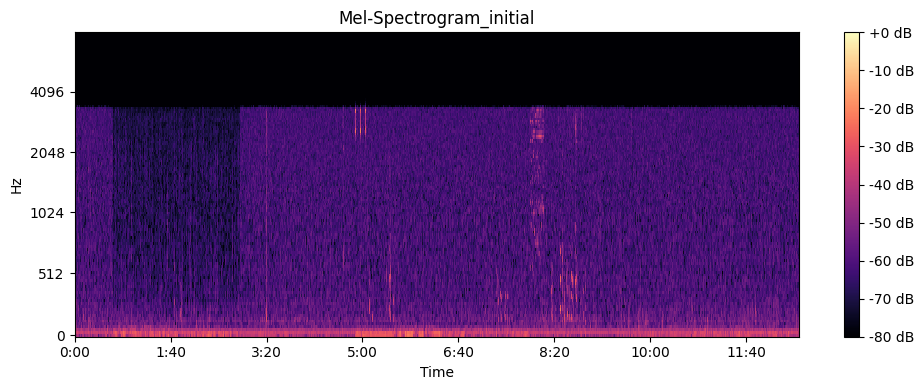

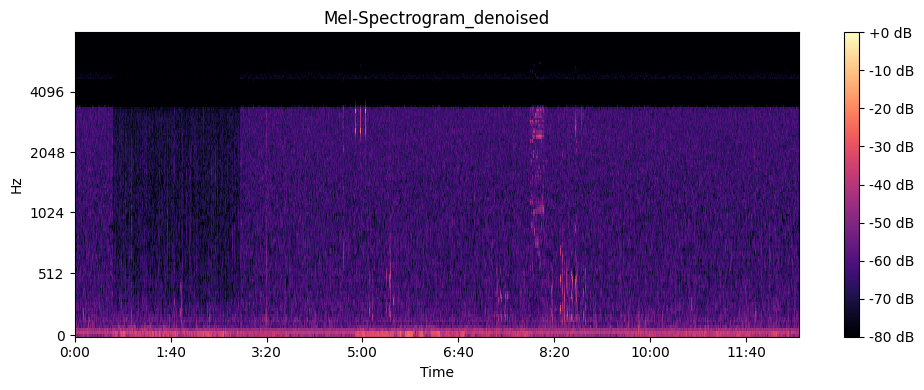

1. Речь. Период действия события: 00:01:43.68 - 00:01:44.64 Длительность: 00:00:0.96
2. Речь. Период действия события: 00:05:10.08 - 00:05:25.44 Длительность: 00:00:15.36
3. Белый шум. Период действия события: 00:05:27.36 - 00:05:29.28 Длительность: 00:00:1.92
4. Белый шум. Период действия события: 00:07:59.04 - 00:08:1.92 Длительность: 00:00:2.88
5. Снаружи, в сельской местности или на природе. Период действия события: 00:08:8.16 - 00:08:16.80 Длительность: 00:00:8.64
6. Белый шум. Период действия события: 00:08:24.96 - 00:08:25.92 Длительность: 00:00:0.96
7. Снаружи, в сельской местности или на природе. Период действия события: 00:08:28.32 - 00:08:34.08 Длительность: 00:00:5.76
8. Тишина. Период действия события: 00:08:35.04 - 00:08:36.00 Длительность: 00:00:0.96
9. Речь. Период действия события: 00:08:39.36 - 00:08:43.20 Длительность: 00:00:3.84
10. Белый шум. Период действия события: 00:08:46.56 - 00:08:48.48 Длительность: 00:00:1.92
События сохранены в audio1_events.csv

Файл: aud

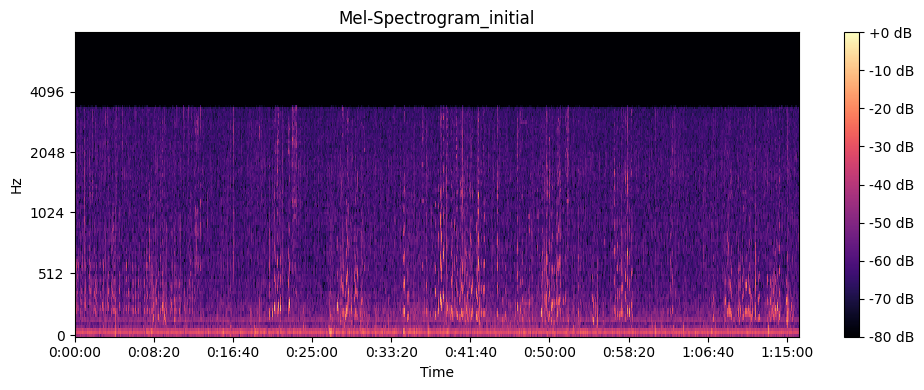

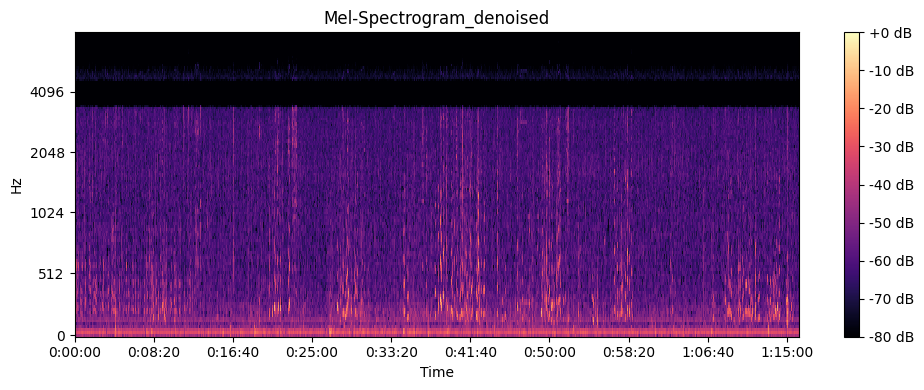

1. Речь. Период действия события: 00:00:0.48 - 00:01:51.84 Длительность: 00:01:51.36
2. Боковой камень. Период действия события: 00:01:56.64 - 00:01:57.60 Длительность: 00:00:0.96
3. Речь. Период действия события: 00:02:12.48 - 00:03:15.84 Длительность: 00:01:3.36
4. Речь. Период действия события: 00:03:32.16 - 00:05:20.16 Длительность: 00:01:48.00
5. Речь. Период действия события: 00:05:40.32 - 00:06:40.80 Длительность: 00:01:0.48
6. Фейерверк. Период действия события: 00:06:41.76 - 00:06:43.68 Длительность: 00:00:1.92
7. Речь. Период действия события: 00:06:47.52 - 00:08:5.28 Длительность: 00:01:17.76
8. Речь. Период действия события: 00:08:7.68 - 00:08:12.96 Длительность: 00:00:5.28
9. Гул. Период действия события: 00:08:20.64 - 00:08:22.56 Длительность: 00:00:1.92
10. Речь. Период действия события: 00:08:24.96 - 00:08:59.04 Длительность: 00:00:34.08
11. Ходьба, шаги. Период действия события: 00:08:59.52 - 00:09:0.48 Длительность: 00:00:0.96
12. Взрыв. Период действия события: 00:09

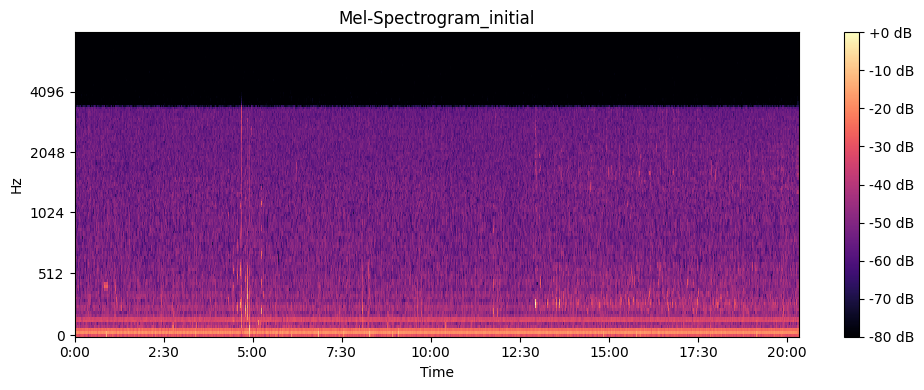

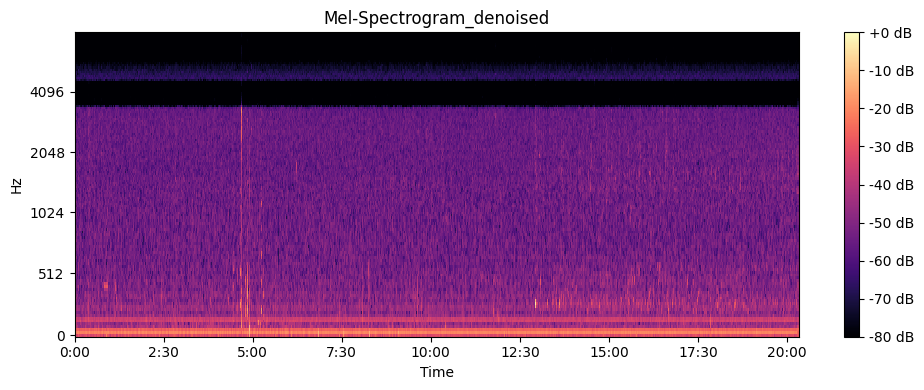

1. Белый шум. Период действия события: 00:04:34.08 - 00:04:36.48 Длительность: 00:00:2.40
2. Гидролокатор. Период действия события: 00:04:37.44 - 00:04:39.84 Длительность: 00:00:2.40
3. Белый шум. Период действия события: 00:04:47.52 - 00:05:10.56 Длительность: 00:00:23.04
4. Гидролокатор. Период действия события: 00:05:12.96 - 00:05:15.36 Длительность: 00:00:2.40
5. Белый шум. Период действия события: 00:05:16.32 - 00:05:17.76 Длительность: 00:00:1.44
6. Белый шум. Период действия события: 00:11:45.60 - 00:11:52.80 Длительность: 00:00:7.20
7. Шум. Период действия события: 00:12:59.52 - 00:13:0.48 Длительность: 00:00:0.96
8. Белый шум. Период действия события: 00:13:37.92 - 00:13:55.20 Длительность: 00:00:17.28
9. Белый шум. Период действия события: 00:15:20.64 - 00:15:35.04 Длительность: 00:00:14.40
10. Белый шум. Период действия события: 00:15:45.60 - 00:16:15.84 Длительность: 00:00:30.24
11. Тишина. Период действия события: 00:17:28.32 - 00:17:29.28 Длительность: 00:00:0.96
События 

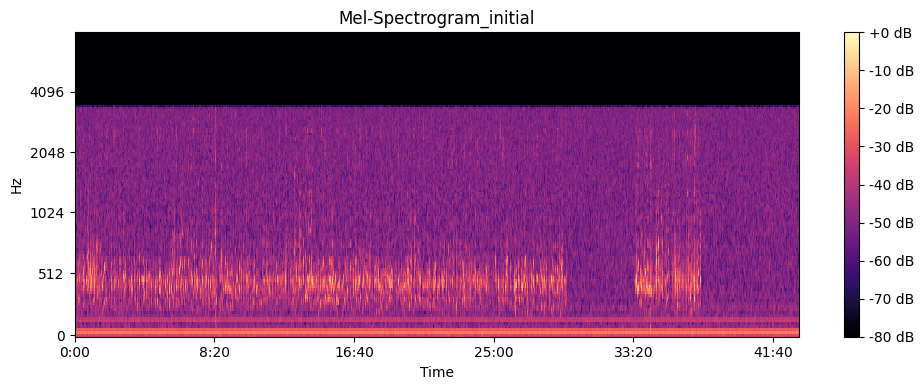

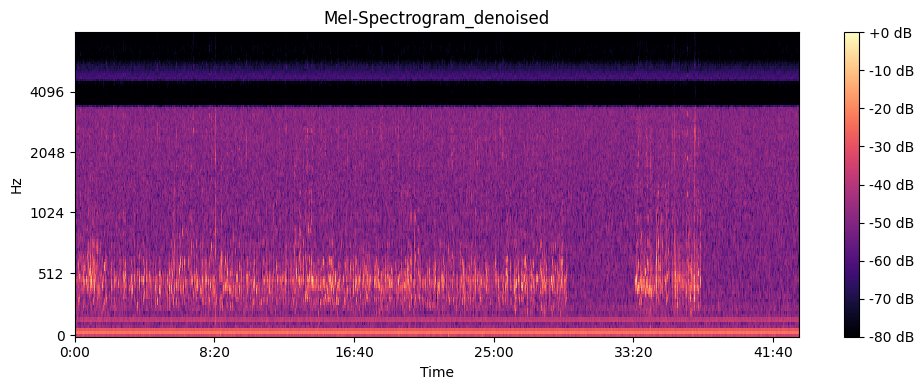

1. Речь. Период действия события: 00:00:13.92 - 00:01:9.60 Длительность: 00:00:55.68
2. Речь. Период действия события: 00:02:18.24 - 00:02:32.64 Длительность: 00:00:14.40
3. Речь. Период действия события: 00:03:18.24 - 00:03:51.36 Длительность: 00:00:33.12
4. Речь. Период действия события: 00:04:36.48 - 00:04:44.64 Длительность: 00:00:8.16
5. Белый шум. Период действия события: 00:05:6.24 - 00:05:14.88 Длительность: 00:00:8.64
6. Змея. Период действия события: 00:05:23.04 - 00:05:24.00 Длительность: 00:00:0.96
7. Речь. Период действия события: 00:05:51.36 - 00:06:7.68 Длительность: 00:00:16.32
8. Речь. Период действия события: 00:06:48.96 - 00:06:57.60 Длительность: 00:00:8.64
9. Речь. Период действия события: 00:09:2.88 - 00:09:53.76 Длительность: 00:00:50.88
10. Речь. Период действия события: 00:10:40.80 - 00:10:41.76 Длительность: 00:00:0.96
11. Речь. Период действия события: 00:13:38.88 - 00:13:57.12 Длительность: 00:00:18.24
12. Речь. Период действия события: 00:14:27.84 - 00:16:2

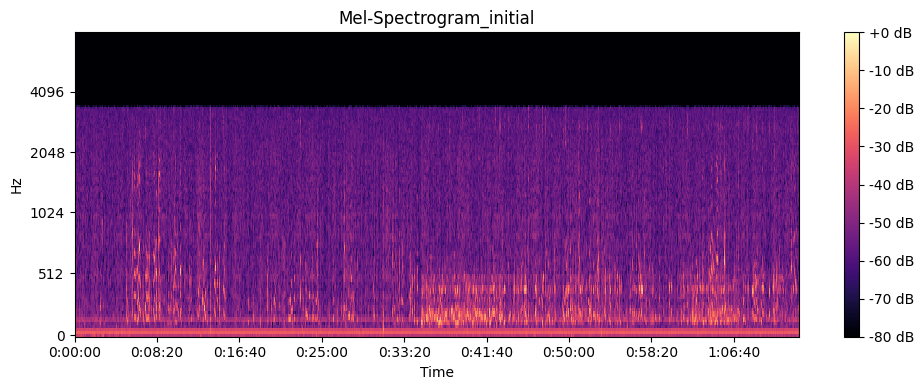

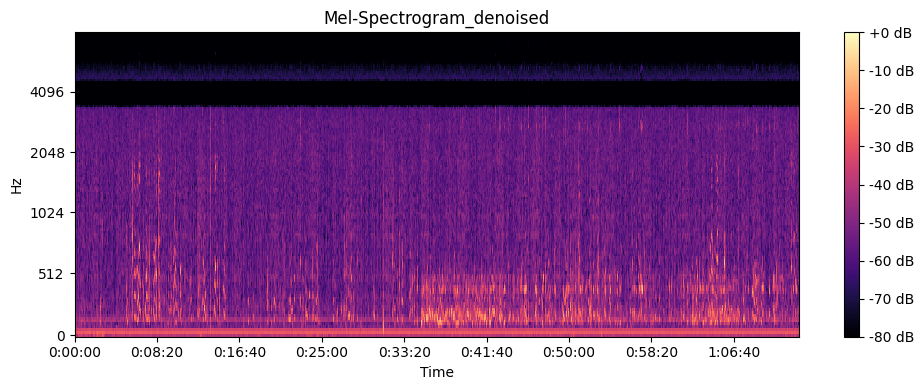

1. Снаружи, в сельской местности или на природе. Период действия события: 00:05:43.68 - 00:05:47.52 Длительность: 00:00:3.84
2. Гул. Период действия события: 00:05:49.44 - 00:05:55.20 Длительность: 00:00:5.76
3. Шум. Период действия события: 00:05:58.08 - 00:06:0.00 Длительность: 00:00:1.92
4. Белый шум. Период действия события: 00:06:1.92 - 00:06:6.72 Длительность: 00:00:4.80
5. Снаружи, в сельской местности или на природе. Период действия события: 00:06:7.68 - 00:06:9.12 Длительность: 00:00:1.44
6. Музыка. Период действия события: 00:06:11.52 - 00:06:12.48 Длительность: 00:00:0.96
7. Транспортное средство. Период действия события: 00:06:14.88 - 00:06:15.84 Длительность: 00:00:0.96
8. Механический вентилятор. Период действия события: 00:06:17.28 - 00:06:18.72 Длительность: 00:00:1.44
9. Взрыв. Период действия события: 00:06:20.16 - 00:06:21.12 Длительность: 00:00:0.96
10. Снаружи, в сельской местности или на природе. Период действия события: 00:06:21.60 - 00:06:24.48 Длительность: 00:

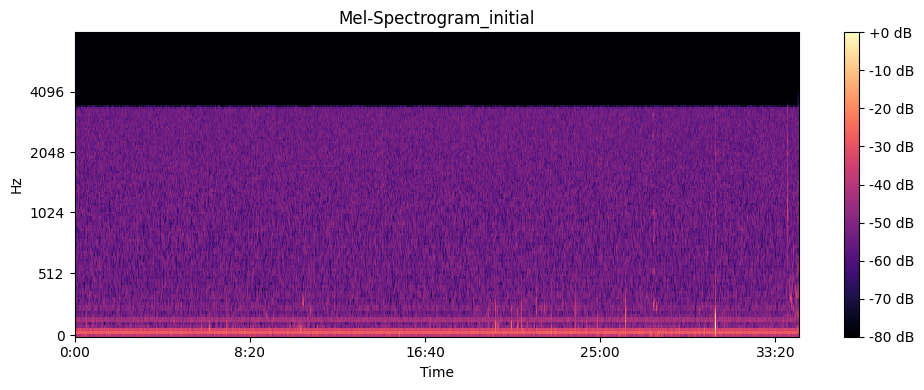

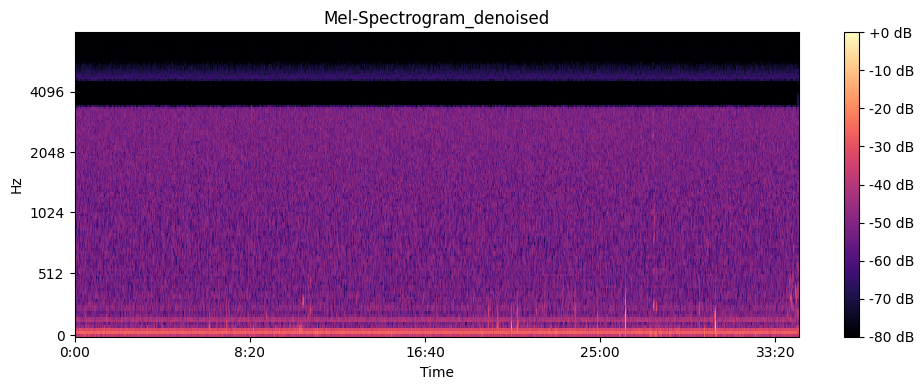

1. Змея. Период действия события: 00:22:10.56 - 00:22:11.52 Длительность: 00:00:0.96
2. Змея. Период действия события: 00:30:16.32 - 00:30:25.44 Длительность: 00:00:9.12
События сохранены в audio6_events.csv

Файл: audio7.mp3


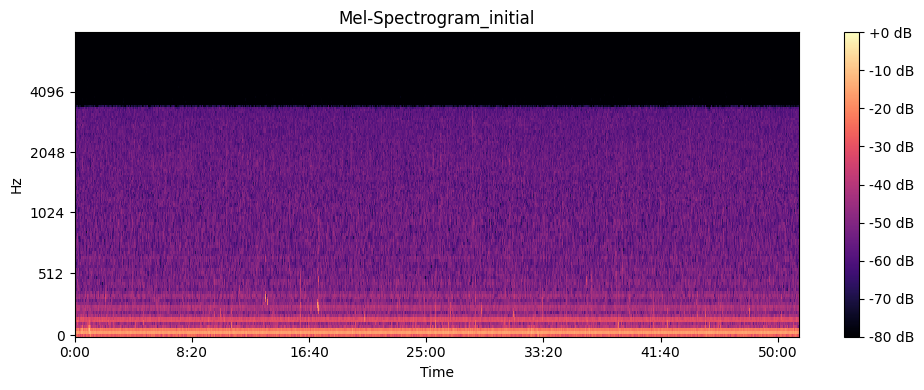

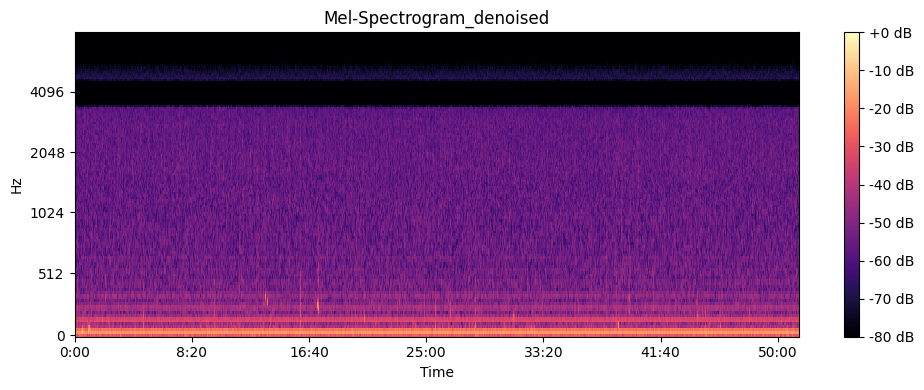

1. Микроволновая печь. Период действия события: 00:11:13.92 - 00:11:14.88 Длительность: 00:00:0.96
2. Шум. Период действия события: 00:24:36.96 - 00:24:37.92 Длительность: 00:00:0.96
События сохранены в audio7_events.csv

Файл: audio8.mp3


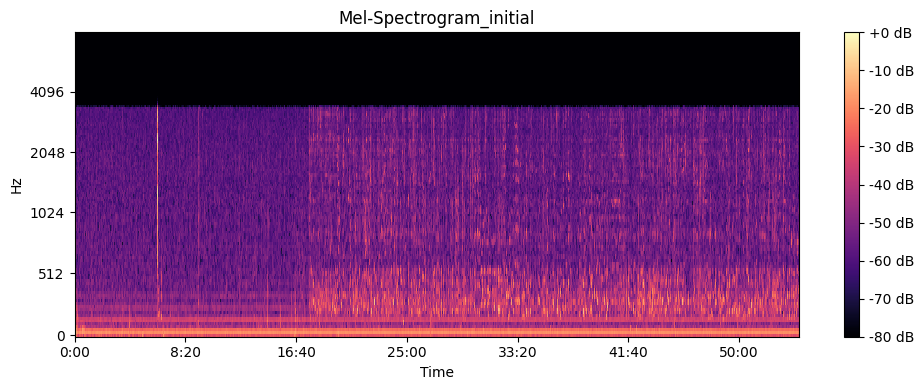

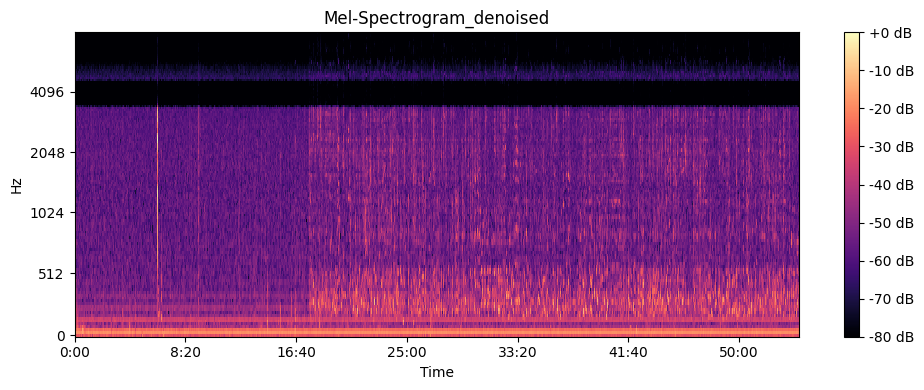

1. Гидролокатор. Период действия события: 00:17:46.56 - 00:17:48.00 Длительность: 00:00:1.44
2. Музыка. Период действия события: 00:18:5.28 - 00:18:6.24 Длительность: 00:00:0.96
3. Тишина. Период действия события: 00:18:42.24 - 00:18:43.20 Длительность: 00:00:0.96
4. Звуковой эффект. Период действия события: 00:19:6.72 - 00:19:7.68 Длительность: 00:00:0.96
5. Тишина. Период действия события: 00:19:53.76 - 00:20:7.20 Длительность: 00:00:13.44
6. Стрела. Период действия события: 00:20:7.68 - 00:20:9.60 Длительность: 00:00:1.92
7. Динь - Динь. Период действия события: 00:20:10.08 - 00:20:14.88 Длительность: 00:00:4.80
8. Динь - Динь. Период действия события: 00:20:38.40 - 00:20:39.84 Длительность: 00:00:1.44
9. Лязг. Период действия события: 00:20:41.28 - 00:20:42.24 Длительность: 00:00:0.96
10. Тишина. Период действия события: 00:20:44.64 - 00:20:49.92 Длительность: 00:00:5.28
11. Динь - Динь. Период действия события: 00:20:55.68 - 00:20:56.64 Длительность: 00:00:0.96
12. Тишина. Период 

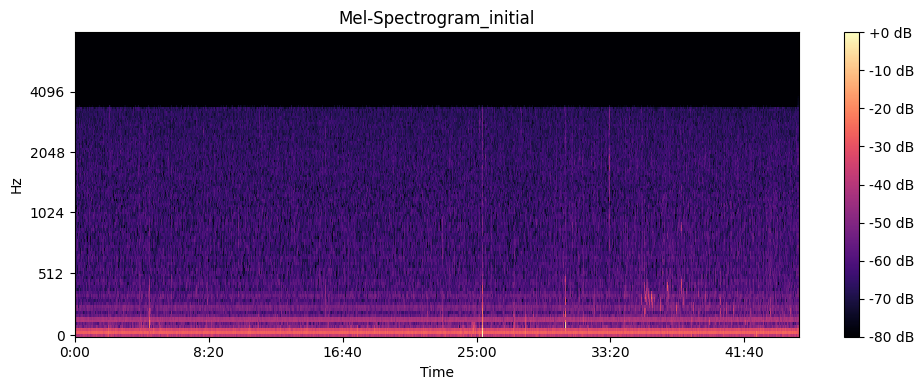

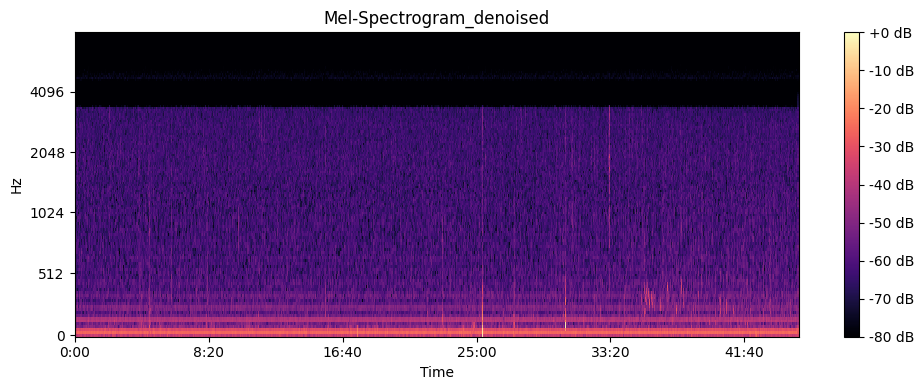

1. Шум. Период действия события: 00:07:40.80 - 00:08:12.48 Длительность: 00:00:31.68
2. Шум. Период действия события: 00:19:32.16 - 00:19:34.56 Длительность: 00:00:2.40
3. Гудение сети. Период действия события: 00:35:58.08 - 00:35:59.04 Длительность: 00:00:0.96
4. Гудение сети. Период действия события: 00:37:21.60 - 00:37:49.92 Длительность: 00:00:28.32
События сохранены в audio9_events.csv

Файл: audio10.mp3


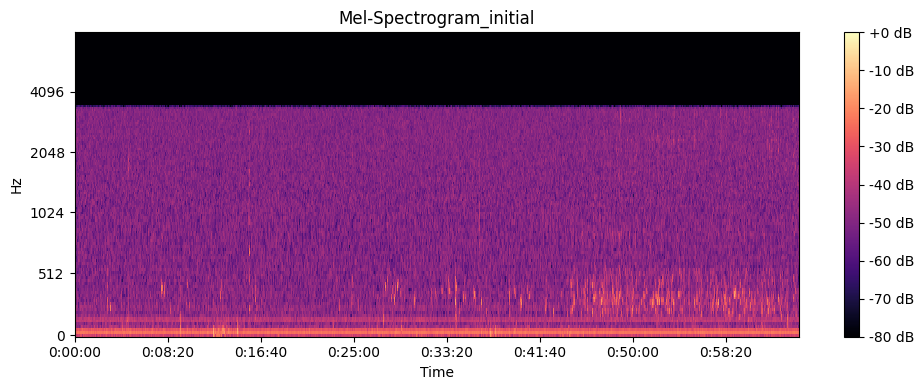

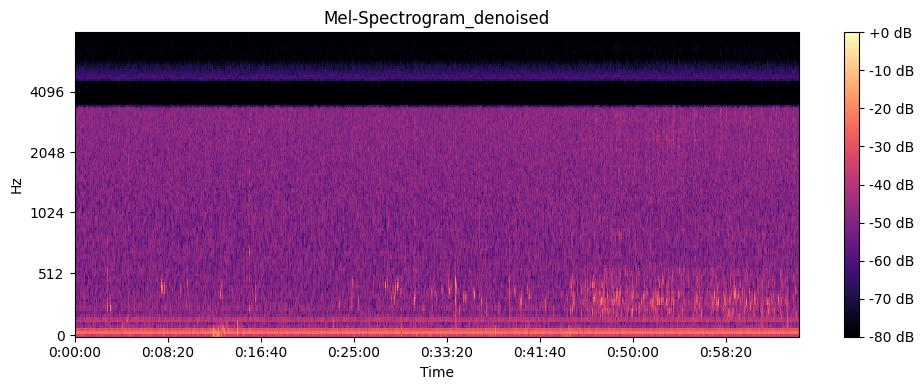

1. Змея. Период действия события: 00:07:49.44 - 00:07:54.24 Длительность: 00:00:4.80
2. Белый шум. Период действия события: 00:08:5.28 - 00:08:6.72 Длительность: 00:00:1.44
3. Змея. Период действия события: 00:28:57.60 - 00:29:0.48 Длительность: 00:00:2.88
4. Белый шум. Период действия события: 00:33:35.52 - 00:33:39.36 Длительность: 00:00:3.84
5. Белый шум. Период действия события: 00:34:10.08 - 00:34:15.36 Длительность: 00:00:5.28
6. Белый шум. Период действия события: 00:40:45.12 - 00:40:48.00 Длительность: 00:00:2.88
7. Белый шум. Период действия события: 00:44:51.36 - 00:45:0.48 Длительность: 00:00:9.12
8. Белый шум. Период действия события: 00:48:5.76 - 00:48:30.24 Длительность: 00:00:24.48
9. Белый шум. Период действия события: 00:52:11.04 - 00:52:23.52 Длительность: 00:00:12.48
10. Белый шум. Период действия события: 00:53:47.52 - 00:54:51.36 Длительность: 00:01:3.84
11. Белый шум. Период действия события: 00:55:59.04 - 00:56:21.12 Длительность: 00:00:22.08
12. Белый шум. Перио

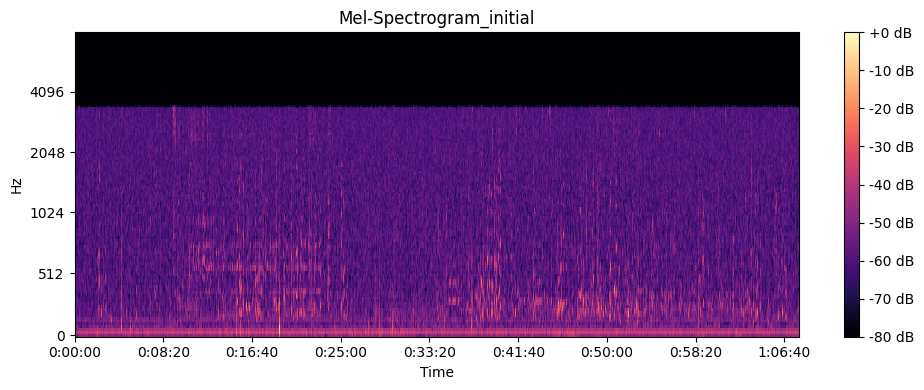

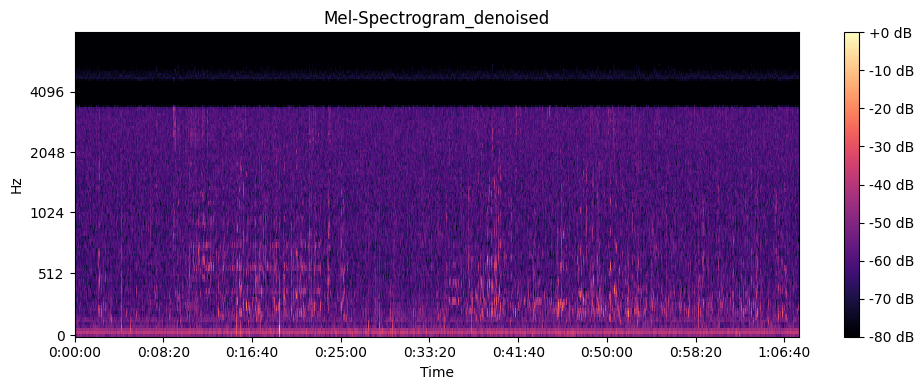

1. Речь. Период действия события: 00:00:3.36 - 00:00:11.52 Длительность: 00:00:8.16
2. Речь. Период действия события: 00:02:13.92 - 00:03:10.56 Длительность: 00:00:56.64
3. Речь. Период действия события: 00:08:27.36 - 00:08:52.32 Длительность: 00:00:24.96
4. Речь. Период действия события: 00:12:33.60 - 00:12:39.84 Длительность: 00:00:6.24
5. Речь. Период действия события: 00:12:55.68 - 00:13:9.12 Длительность: 00:00:13.44
6. Речь. Период действия события: 00:13:25.44 - 00:13:43.68 Длительность: 00:00:18.24
7. Сова. Период действия события: 00:13:44.64 - 00:13:46.08 Длительность: 00:00:1.44
8. Речь. Период действия события: 00:13:46.56 - 00:13:50.88 Длительность: 00:00:4.32
9. Шум. Период действия события: 00:13:59.52 - 00:14:11.04 Длительность: 00:00:11.52
10. Снаружи, в сельской местности или на природе. Период действия события: 00:15:18.72 - 00:15:23.52 Длительность: 00:00:4.80
11. Шум. Период действия события: 00:15:25.44 - 00:15:26.88 Длительность: 00:00:1.44
12. Белый шум. Период 

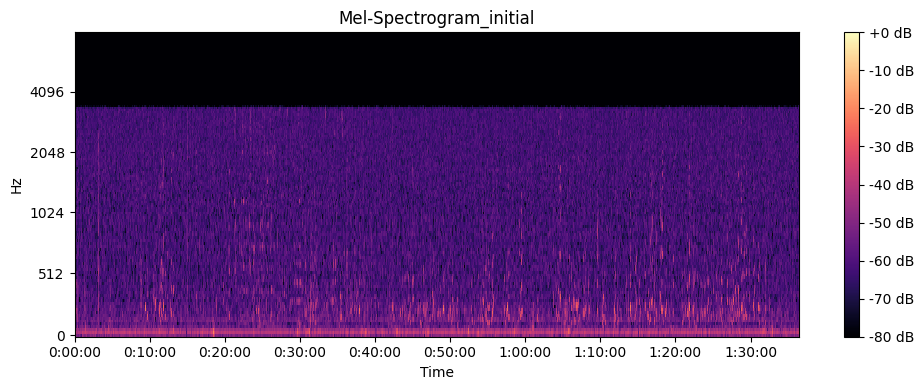

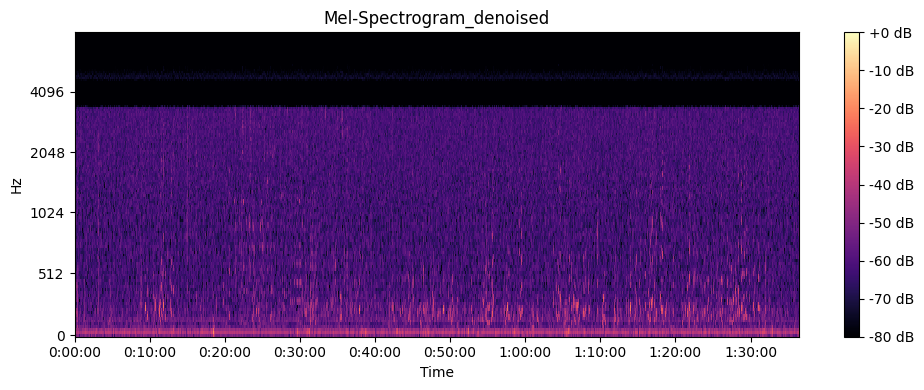

1. Речь. Период действия события: 00:08:16.32 - 00:08:22.56 Длительность: 00:00:6.24
2. Музыка. Период действия события: 00:11:8.64 - 00:11:9.60 Длительность: 00:00:0.96
3. Шум. Период действия события: 00:11:12.00 - 00:11:13.92 Длительность: 00:00:1.92
4. Речь. Период действия события: 00:11:18.24 - 00:11:23.04 Длительность: 00:00:4.80
5. Белый шум. Период действия события: 00:11:23.52 - 00:11:24.96 Длительность: 00:00:1.44
6. Снаружи, в сельской местности или на природе. Период действия события: 00:11:26.40 - 00:11:27.84 Длительность: 00:00:1.44
7. Змея. Период действия события: 00:11:29.28 - 00:11:30.72 Длительность: 00:00:1.44
8. Речь. Период действия события: 00:11:34.08 - 00:11:39.36 Длительность: 00:00:5.28
9. Белый шум. Период действия события: 00:11:40.32 - 00:11:41.28 Длительность: 00:00:0.96
10. Речь. Период действия события: 00:11:42.24 - 00:11:49.92 Длительность: 00:00:7.68
11. Речь. Период действия события: 00:12:10.56 - 00:12:48.48 Длительность: 00:00:37.92
12. Шум. Пери

In [3]:
# Параметры

n_fft = 1024  # Размер окна Фурье
hop_length = 512  # Шаг смещения окна
n_mels = 128  # Количество мел-полос
desired_sample_rate=16000 # частота дискретизации
preemphasis_coef=0.25 # Коэффициент преэмфазного шумоподавления
adaptive_filtered=True # Применять ли адаптивную фильтрацию сигнала
wavelet_filtered=True # Применять ли вейвлет-шумоподавление сигнала
n=512 # количество коэффициентов адаптивного фильтра
noise_level = 0.05 # порог адаптивного шумоподавления
threshold = 0.95 # порога уверенности классификации моделью YAMNet

# Функция адаптивного фильтра
def adaptive_filter(y, noise, n):
    b = firwin(n, cutoff=0.5, window='hamming')
    z = lfilter_zi(b, 1)
    filtered_signal, _ = lfilter(b, 1, y, zi=z*y[0])
    return filtered_signal

# Функция шумоподавления на вейвлет-преобразованиях
def wavelet_denoise(data, wavelet='db8', level=3):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    limit = np.std(coeffs[-level]) / 10
    thresholded_coeffs = [pywt.threshold(c, limit, mode='soft') if i == level else c for i, c in enumerate(coeffs)]
    return pywt.waverec(thresholded_coeffs, wavelet)

# Функция для предобработки и анализа аудиодорожек
def preprocess_audio(file_path, model, desired_sample_rate=desired_sample_rate, preemphasis_coef=preemphasis_coef):
    # Проверка существования файла
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден")

    # Конвертация из MP3 в WAV
    with open(file_path, "rb") as f:
        audio = AudioSegment.from_mp3(f)
    audio = audio.set_frame_rate(desired_sample_rate).set_channels(1)
    buffer = io.BytesIO()
    audio.export(buffer, format="wav")
    buffer.seek(0)

    # Декодирование WAV и предобработка
    y, _ = tf.audio.decode_wav(buffer.read(), desired_channels=1)
    y = tf.squeeze(y, axis=-1).numpy()

    # Получение мел-спектрограммы и преобразование в децибелы исходного сигнала
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=desired_sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=desired_sample_rate/2)
    mel_spectrogram_db_start = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Применяем преэмфазное шумоподавление для выделения высокочастотных компонентов аудиосигнала
    if preemphasis_coef is not None:
        y = librosa.effects.preemphasis(y, coef=preemphasis_coef)
        y = librosa.util.normalize(y)

    # Применение адаптивного фильтра для очистки изменяющегося фонового шума
    if adaptive_filtered:
        y = adaptive_filter(y, noise_level, n)
        y = librosa.util.normalize(y)

    # Применяем вейвлет-шумоподавление для финального удаления шума с сохранением деталей сигнала
    if wavelet_filtered:
        y = wavelet_denoise(y)
        y = librosa.util.normalize(y)

    # Анализ с помощью YAMNet
    scores, embeddings, spectrogram = model(y)

    # Получение мел-спектрограммы и преобразование в децибелы очищенного сигнала
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=desired_sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=desired_sample_rate/2)
    mel_spectrogram_db_clear = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return scores, embeddings, spectrogram, mel_spectrogram_db_start, mel_spectrogram_db_clear

# Функция детекции звуковых событий
def predict_sound_events_yamnet(file_path, model, class_map, threshold):

    # При работе с предобученной моделью используем только score.
    # Embeddings и spectrogram понадобятся впоследствии для дообучения своей нейросети с использованием собственного размеченного датасета.
    scores, embeddings, spectrogram, mel_spectrogram_db_start, mel_spectrogram_db_clear = preprocess_audio(file_path, model)
    scores = scores.numpy()  # Преобразование тензора TensorFlow в массив NumPy

    # Получение индексов класса с максимальной вероятностью для каждого временного шага
    class_ids = np.argmax(scores, axis=1)
    class_descriptions = class_map.iloc[class_ids, 3]

    # Здесь реализуем упрощенный вариант детекции по одному классу на каждый момент времени (с наибольшей вероятностью по мнению модели YamNet).
    # Впоследствии код можно доработать в сторону мультидетекции.

    # Определение временных границ событий
    events = []
    event_start = None
    for i in range(scores.shape[0]):
        max_score = np.max(scores[i])
        if max_score > threshold and event_start is None:
            event_start = i
        elif (max_score <= threshold or i == scores.shape[0] - 1) and event_start is not None:
            event_end = i
            events.append((event_start, event_end))
            event_start = None

    # Преобразование индексов событий в временные метки
    event_times = [(0.48 * start, 0.48 * end) for start, end in events]

    return class_descriptions, event_times, mel_spectrogram_db_start, mel_spectrogram_db_clear

# Функция группировки череды одинаковых событий в одно общее событие
def group_events(event_times, descriptions, time_threshold=1.0):
    if len(event_times) == 0:
        return []

    grouped_events = []
    current_start, current_end = event_times[0]
    current_description = descriptions[0]

    for (next_start, next_end), next_description in zip(event_times[1:], descriptions[1:]):
        # Если следующее событие отличается или разрыв больше порога, завершаем текущее событие
        if current_description != next_description or (next_start - current_end) > time_threshold:
            grouped_events.append((current_description, current_start, current_end))
            current_description = next_description
            current_start = next_start

        current_end = next_end

    # Добавляем последнее событие
    grouped_events.append((current_description, current_start, current_end))

    return grouped_events

# Функция для преобразования секунд в формат hh:mm:ss
def seconds_to_hh_mm_ss(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f'{int(hours):02d}:{int(minutes):02d}:{seconds:.2f}'

# ОСНОВНОЕ ТЕЛО
# Проходим по всем аудиофайлам и детектируем звуковые события с использованием предобработки и модели Yamnet
for path in audio_paths:
    cnt = 0
    predicted_descriptions_yamnet, onset_times_yamnet, mel_spectrogram_db_start, mel_spectrogram_db_clear = predict_sound_events_yamnet(path, yamnet_model, class_map, threshold)
    print(f"Файл: {os.path.basename(path)}")
    # Визуализация исходной мел-спектрограммы
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db_start, x_axis='time', y_axis='mel', sr=desired_sample_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram_initial')
    plt.tight_layout()
    plt.show()
    plt.close()
    # Визуализация очищенной мел-спектрограммы
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db_clear, x_axis='time', y_axis='mel', sr=desired_sample_rate)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-Spectrogram_denoised')
    plt.tight_layout()
    plt.show()
    plt.close()

    events_data = []
    if len(onset_times_yamnet) > 0 and len(predicted_descriptions_yamnet) > 0:
        # Преобразование Pandas Series в список, если это необходимо
        if isinstance(predicted_descriptions_yamnet, pd.Series):
            predicted_descriptions_yamnet = predicted_descriptions_yamnet.tolist()

        # Группировка событий
        grouped_events = group_events(onset_times_yamnet, predicted_descriptions_yamnet, time_threshold=30.0)
        for (description, start_time, end_time) in grouped_events:
            formatted_start = seconds_to_hh_mm_ss(start_time)
            formatted_end = seconds_to_hh_mm_ss(end_time)
            duration = seconds_to_hh_mm_ss(end_time - start_time)
            if end_time - start_time >= 0.5: # фильтр импульсных срабатываний
              cnt += 1
              print(f'{cnt}. {description}. Период действия события: {formatted_start} - {formatted_end} Длительность: {duration}')
              events_data.append([cnt, description, formatted_start, formatted_end, duration])
    else:
        print(f"Нет обнаруженных событий в файле {os.path.basename(path)}")

        # Сохранение событий в csv-файлы
    if events_data:
        events_df = pd.DataFrame(events_data, columns=['Номер', 'Описание', 'Начало', 'Окончание', 'Длительность'])
        csv_filename = f"{os.path.splitext(os.path.basename(path))[0]}_events.csv"
        events_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"События сохранены в {csv_filename}")

    gc.collect() # почистим память после обработки каждого файла
    print()